In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os
import bambi as bmb

from formulae import design_matrices

In [59]:
data = pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/train.csv') #reading in final data
data.columns

Index(['STATE', 'gun_own', 'hunt_license', 'background_checks',
       'gun_permit_law', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col', 'population', 'n',
       'gun_strictness', 'rural', 'suburban', 'urban'],
      dtype='object')

In [60]:
data.dropna(inplace = True) #dropping NAs

In [63]:
#scaling all data
columns_to_scale = ['gun_own',
       'hunt_license', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col',
       'population', 'gun_strictness']

data[columns_to_scale] = data[columns_to_scale].apply(lambda x : (x - np.mean(x))/np.std(x))

fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Unemployment_rate_2021  Median_Household_Income_2020   ba_plus  \
0                  -1.054016                      0.694312  0.589642   
1                  -0.940531                      0.939418  0.960109   
2                   0.591523                     -1.276080 -1.134098   
3                  -0.656817                     -0.449379 -1.161714   
4                  -1.280987                     -0.154428 -0.965131   
...                      ...                           ...       ...   
3136                0.534781                      0.901519 -0.143786   
3137               -0.827045                      2.405455  3.348400   
3138                0.194324                      0.947039 -0.361401   
3139               -0.373103                      0.074132  0.124250   
3140               -0.827045                      0.099466 -0.558660   

      less_than_hs        hs  some_col  population  gun_strictness  
0        -0.184500 -0.346835 -0.382626   -0.145751       -1.154567  
1        -0.475586 -0.917436  0.061710    0.355878       -1.154567  
2         2.131007  0.245205 -0.690082   -0.239213       -1.154567  
3         1.112068  1.511475 -1.235287   -0.246082       -1.154567  
4         0.790681  0.158194  0.638844   -0.139885       -1.154567  
...            ...       ...       ...         ...             ...  
3136     -0.823092 -0.224346  1.501087   -0.186291       -2.055884  
3137     -1.173494 -2.484783 -1.319654   -0.242875       -2.055884  
3138     -0.911429  0.505643  0.988468   -0.252580       -2.055884  
3139     -0.729335 -0.699993  1.565122   -0.289808       -2.055884  
3140     -0.949096  0.572114  1.297233   -0.292440       -2.055884  

[3141 rows x 19 columns]

In [64]:
quick_prior_change = 5

with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [68]:
with mdl_fish:
    inf_fish = pm.sample(1000, tune=1000, target_accept = 0.9, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hunt_license, gun_own, gun_strictness, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 786 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


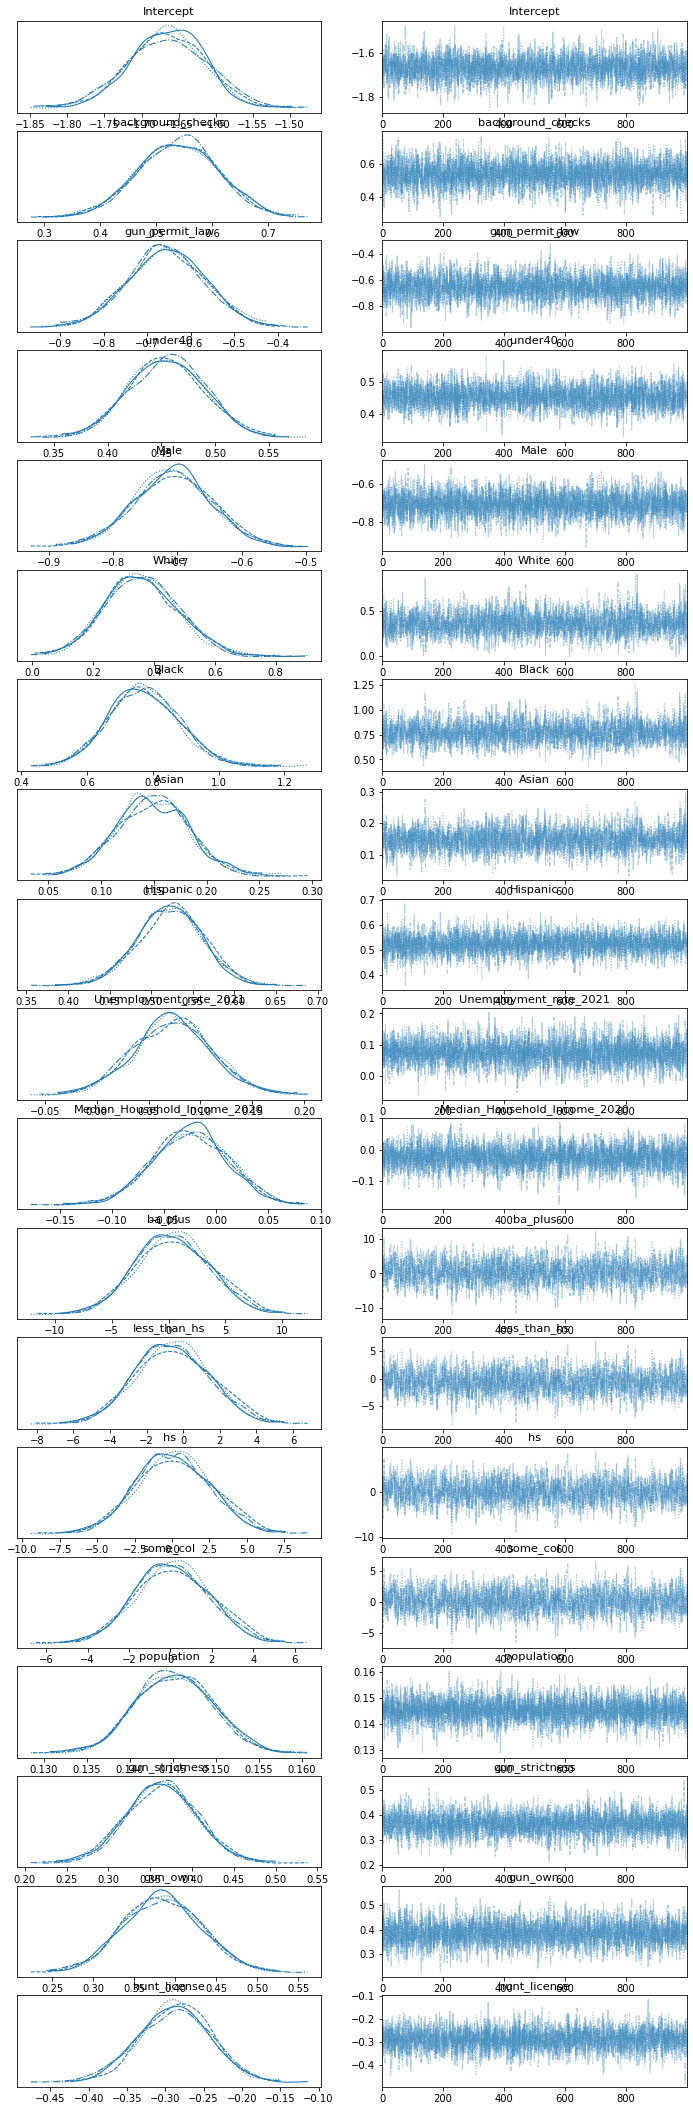

In [69]:
az.plot_trace(inf_fish);

In [70]:
az.summary(inf_fish, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -1.666  0.052  -1.771   -1.575
background_checks             0.538  0.073   0.411    0.685
gun_permit_law               -0.656  0.088  -0.811   -0.481
under40                       0.455  0.034   0.393    0.520
Male                         -0.708  0.060  -0.820   -0.591
White                         0.359  0.123   0.121    0.580
Black                         0.773  0.107   0.567    0.963
Asian                         0.149  0.034   0.083    0.212
Hispanic                      0.523  0.039   0.452    0.600
Unemployment_rate_2021        0.073  0.038   0.003    0.147
Median_Household_Income_2020 -0.025  0.036  -0.093    0.040
ba_plus                       0.404  3.316  -5.560    6.785
less_than_hs                 -0.588  2.068  -4.328    3.372
hs                            0.106  2.522  -4.390    4.996
some_col                      0.120  1.828  -3.192    3.608
population                    0.145  0.004   0.138    0.154
gun_strictness                0.363  0.042   0.286    0.443
gun_own                       0.385  0.047   0.298    0.475
hunt_license                 -0.288  0.046  -0.377   -0.204

In [20]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Unemployment_rate_2021  Median_Household_Income_2020  population  \
0                  -1.054016                      0.694312   -0.145751   
1                  -0.940531                      0.939418    0.355878   
2                   0.591523                     -1.276080   -0.239213   
3                  -0.656817                     -0.449379   -0.246082   
4                  -1.280987                     -0.154428   -0.139885   
...                      ...                           ...         ...   
3136                0.534781                      0.901519   -0.186291   
3137               -0.827045                      2.405455   -0.242875   
3138                0.194324                      0.947039   -0.252580   
3139               -0.373103                      0.074132   -0.289808   
3140               -0.827045                      0.099466   -0.292440   

      gun_strictness  
0          -1.154567  
1          -1.154567  
2          -1.154567  
3          -1.154567  
4          -1.154567  
...              ...  
3136       -2.055884  
3137       -2.055884  
3138       -2.055884  
3139       -2.055884  
3140       -2.055884  

[3141 rows x 15 columns]

In [71]:
quick_prior_change = 5

with pm.Model() as mdl_fish_2:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    # b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    # b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    # b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    # b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        # + b11 * mx_ex["ba_plus"].values
        # + b12 * mx_ex["less_than_hs"].values
        # + b13 * mx_ex["hs"].values
        # + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [73]:
with mdl_fish_2:
    inf_fish_2 = pm.sample(1000, tune=1000, init='adapt_diag')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hunt_license, gun_own, gun_strictness, population, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


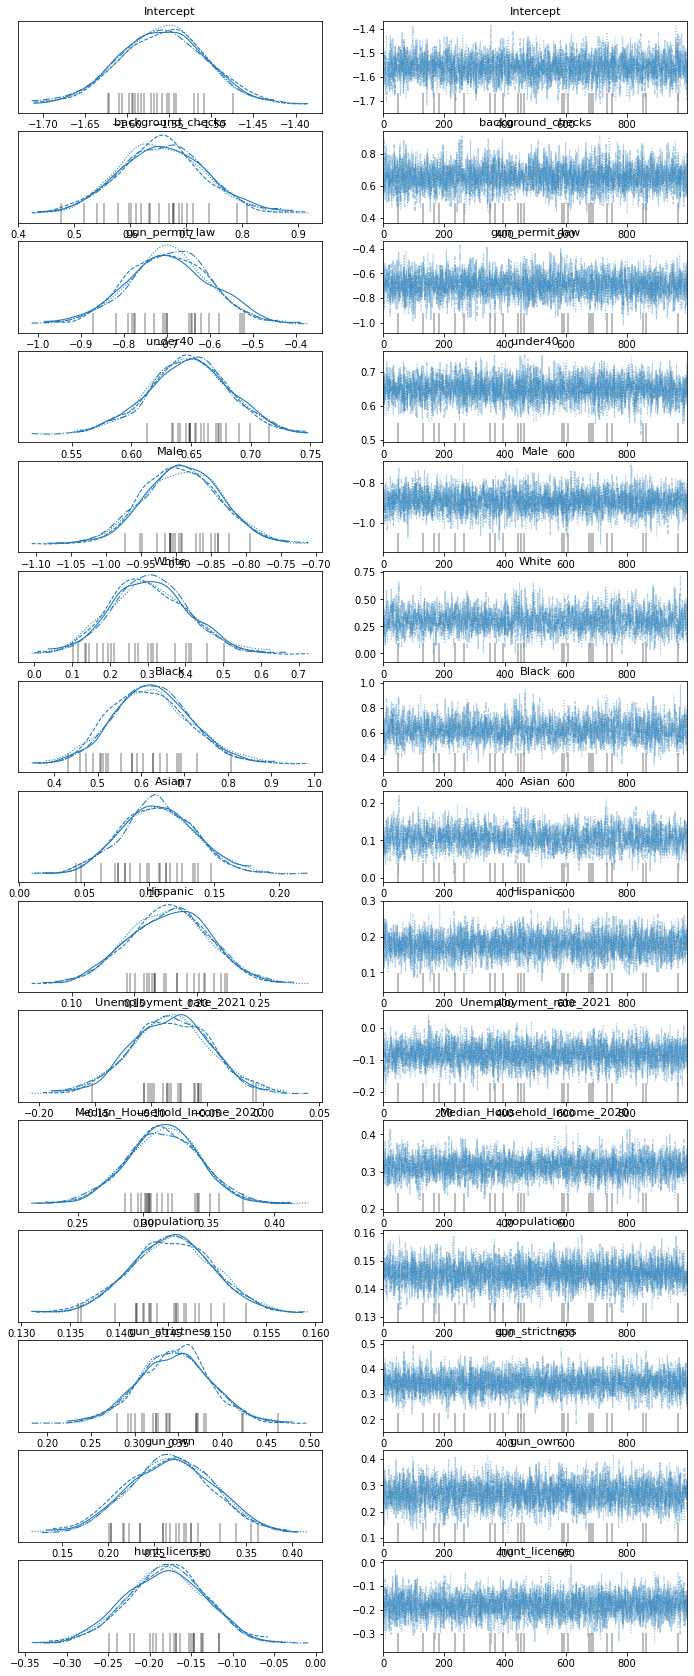

In [74]:
az.plot_trace(inf_fish_2);

In [75]:
az.summary(inf_fish_2, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -1.559  0.051  -1.655   -1.465
background_checks             0.657  0.077   0.517    0.809
gun_permit_law               -0.695  0.095  -0.878   -0.517
under40                       0.648  0.034   0.585    0.714
Male                         -0.891  0.054  -0.990   -0.789
White                         0.306  0.104   0.112    0.497
Black                         0.624  0.090   0.459    0.795
Asian                         0.107  0.028   0.056    0.161
Hispanic                      0.177  0.032   0.116    0.234
Unemployment_rate_2021       -0.083  0.035  -0.146   -0.015
Median_Household_Income_2020  0.315  0.028   0.260    0.363
population                    0.145  0.004   0.137    0.153
gun_strictness                0.346  0.041   0.272    0.427
gun_own                       0.268  0.047   0.183    0.357
hunt_license                 -0.180  0.047  -0.273   -0.096

In [78]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + population + gun_strictness + rural + suburban + urban"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  ...  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231  ...   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758  ...   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357  ...   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765  ...   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066  ...   
...        ...       ...       ...       ...       ...  ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  ...   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  ...   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069  ...   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  ...   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853  ...   

      Median_Household_Income_2020   ba_plus  less_than_hs        hs  \
0                         0.694312  0.589642     -0.184500 -0.346835   
1                         0.939418  0.960109     -0.475586 -0.917436   
2                        -1.276080 -1.134098      2.131007  0.245205   
3                        -0.449379 -1.161714      1.112068  1.511475   
4                        -0.154428 -0.965131      0.790681  0.158194   
...                            ...       ...           ...       ...   
3136                      0.901519 -0.143786     -0.823092 -0.224346   
3137                      2.405455  3.348400     -1.173494 -2.484783   
3138                      0.947039 -0.361401     -0.911429  0.505643   
3139                      0.074132  0.124250     -0.729335 -0.699993   
3140                      0.099466 -0.558660     -0.949096  0.572114   

      some_col  population  gun_strictness  rural  suburban  urban  
0    -0.382626   -0.145751       -1.154567    0.0       0.0    1.0  
1     0.061710    0.355878       -1.154567    0.0       0.0    1.0  
2    -0.690082   -0.239213       -1.154567    0.0       1.0    0.0  
3    -1.235287   -0.246082       -1.154567    0.0       0.0    1.0  
4     0.638844   -0.139885       -1.154567    0.0       0.0    1.0  
...        ...         ...             ...    ...       ...    ...  
3136  1.501087   -0.186291       -2.055884    0.0       1.0    0.0  
3137 -1.319654   -0.242875       -2.055884    1.0       0.0    0.0  
3138  0.988468   -0.252580       -2.055884    1.0       0.0    0.0  
3139  1.565122   -0.289808       -2.055884    1.0       0.0    0.0  
3140  1.297233   -0.292440       -2.055884    1.0       0.0    0.0  

[3141 rows x 22 columns]

In [80]:
quick_prior_change = 5

with pm.Model() as mdl_fish_3:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("Background Checks", sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("Gun Permit Law", sigma=quick_prior_change)
    b3 = pm.Normal("Under 40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment Rate 2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median Household Income 2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("College Degree", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("Less than HS", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("High School Degree", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("Some College", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("Population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("Gun Law Strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("Gun Ownership", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("Hunting License", mu=0, sigma=quick_prior_change)
    b19 = pm.Normal("Urban", mu=0, sigma=quick_prior_change)
    b20 = pm.Normal("Suburban", mu=0, sigma=quick_prior_change)
    b21 = pm.Normal("Rural", mu=0, sigma=quick_prior_change)

    psi = pm.Beta('psi', 1, 1)
    
    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        + b19 * mx_ex["urban"].values
        + b20 * mx_ex["suburban"].values
        + b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.ZeroInflatedPoisson("y", psi = psi, theta=pm.math.exp(theta), observed=mx_en["n"].values)

In [81]:
with mdl_fish_3:
    inf_fish_3 = pm.sample(1000, tune=1000, init="adapt_diag")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Rural, Suburban, Urban, Hunting License, Gun Ownership, Gun Law Strictness, Population, Some College, High School Degree, Less than HS, College Degree, Median Household Income 2020, Unemployment Rate 2021, Hispanic, Asian, Black, White, Male, Under 40, Gun Permit Law, Background Checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1180 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [82]:
az.plot_trace(inf_fish_3);

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


In [83]:
az.summary(inf_fish_3, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -1.161  2.546  -5.703    3.827
Background Checks             0.415  0.079   0.273    0.570
Gun Permit Law               -0.467  0.097  -0.641   -0.283
Under 40                      0.273  0.041   0.198    0.353
Male                         -0.447  0.071  -0.578   -0.317
White                         0.169  0.136  -0.089    0.414
Black                         0.465  0.119   0.245    0.686
Asian                         0.107  0.039   0.035    0.179
Hispanic                      0.335  0.044   0.252    0.418
Unemployment Rate 2021        0.131  0.044   0.045    0.211
Median Household Income 2020 -0.209  0.045  -0.295   -0.126
College Degree                0.126  3.290  -6.181    5.984
Less than HS                 -0.457  2.051  -4.294    3.305
High School Degree           -0.158  2.503  -4.881    4.350
Some College                 -0.098  1.814  -3.452    3.255
Population                    0.113  0.005   0.104    0.122
Gun Law Strictness            0.198  0.043   0.117    0.278
Gun Ownership                 0.256  0.052   0.165    0.353
Hunting License              -0.175  0.048  -0.266   -0.090
Urban                         0.831  2.544  -3.975    5.540
Suburban                     -0.508  2.547  -5.392    4.149
Rural                        -1.371  2.550  -6.277    3.269
psi                           0.597  0.025   0.552    0.644

In [84]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Median_Household_Income_2020 + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Median_Household_Income_2020  population  gun_strictness  
0                         0.694312   -0.145751       -1.154567  
1                         0.939418    0.355878       -1.154567  
2                        -1.276080   -0.239213       -1.154567  
3                        -0.449379   -0.246082       -1.154567  
4                        -0.154428   -0.139885       -1.154567  
...                            ...         ...             ...  
3136                      0.901519   -0.186291       -2.055884  
3137                      2.405455   -0.242875       -2.055884  
3138                      0.947039   -0.252580       -2.055884  
3139                      0.074132   -0.289808       -2.055884  
3140                      0.099466   -0.292440       -2.055884  

[3141 rows x 14 columns]

In [85]:
quick_prior_change = 5

with pm.Model() as mdl_fish_4:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("Background Checks", sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("Gun Permit Law", sigma=quick_prior_change)
    b3 = pm.Normal("Under 40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    #b9 = pm.Normal("Unemployment Rate 2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median Household Income 2020", mu=0, sigma=quick_prior_change)
    #b11 = pm.Normal("College Degree", mu=0, sigma=quick_prior_change)
    #b12 = pm.Normal("Less than HS", mu=0, sigma=quick_prior_change)
    #b13 = pm.Normal("High School Degree", mu=0, sigma=quick_prior_change)
    #b14 = pm.Normal("Some College", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("Population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("Gun Law Strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("Gun Ownership", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("Hunting License", mu=0, sigma=quick_prior_change)
    #b19 = pm.Normal("Urban", mu=0, sigma=quick_prior_change)
    #b20 = pm.Normal("Suburban", mu=0, sigma=quick_prior_change)
    #b21 = pm.Normal("Rural", mu=0, sigma=quick_prior_change)

    psi = pm.Beta('psi', 1, 1)
    
    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        #+ b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        #+ b11 * mx_ex["ba_plus"].values
        #+ b12 * mx_ex["less_than_hs"].values
        #+ b13 * mx_ex["hs"].values
        #+ b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        #+ b19 * mx_ex["urban"].values
        #+ b20 * mx_ex["suburban"].values
        #+ b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.ZeroInflatedPoisson("y", psi = psi, theta=pm.math.exp(theta), observed=mx_en["n"].values)

In [86]:
with mdl_fish_4:
    inf_fish_4 = pm.sample(1000, tune=1000, init="adapt_diag")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Hunting License, Gun Ownership, Gun Law Strictness, Population, Median Household Income 2020, Hispanic, Asian, Black, White, Male, Under 40, Gun Permit Law, Background Checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


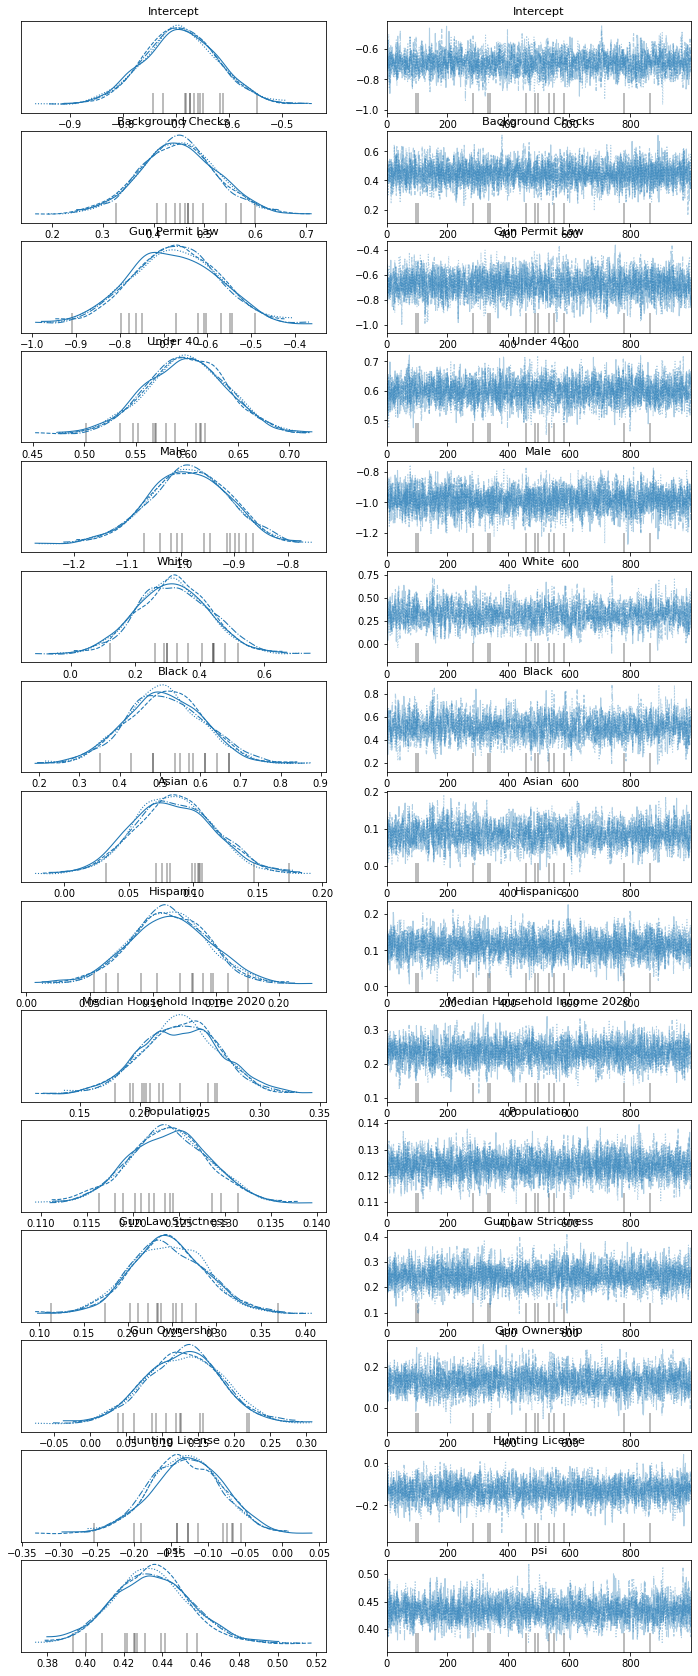

In [87]:
az.plot_trace(inf_fish_4);

In [88]:
az.summary(inf_fish_4, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -0.691  0.069  -0.815   -0.555
Background Checks             0.448  0.074   0.311    0.592
Gun Permit Law               -0.676  0.099  -0.854   -0.486
Under 40                      0.600  0.039   0.524    0.672
Male                         -0.986  0.076  -1.127   -0.841
White                         0.318  0.112   0.107    0.529
Black                         0.513  0.098   0.332    0.693
Asian                         0.085  0.031   0.030    0.143
Hispanic                      0.113  0.031   0.057    0.171
Median Household Income 2020  0.234  0.032   0.173    0.294
Population                    0.124  0.004   0.115    0.132
Gun Law Strictness            0.245  0.043   0.168    0.329
Gun Ownership                 0.130  0.053   0.028    0.227
Hunting License              -0.130  0.048  -0.220   -0.040
psi                           0.434  0.020   0.396    0.472

In [89]:
df_comp_loo = az.compare({"pooled_all": inf_fish, "pooled_selected": inf_fish_2, 'pooled_zero_inflated_all':inf_fish_3, 'pooled_zero_inflated_selected':inf_fish_4})
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Got error No model on context stack. trying to find log

rank          loo       p_loo       d_loo  \
pooled_zero_inflated_all          0 -2203.738508   80.637541    0.000000   
pooled_zero_inflated_selected     1 -2453.658892   83.835185  249.920384   
pooled_all                        2 -2636.740824   99.908583  433.002316   
pooled_selected                   3 -2814.756573  102.391163  611.018065   

                                 weight          se        dse  warning  \
pooled_zero_inflated_all       0.808154  170.072374   0.000000     True   
pooled_zero_inflated_selected  0.019430  180.804827  31.906705     True   
pooled_all                     0.037396  222.300111  65.718097     True   
pooled_selected                0.135020  224.881860  77.891770     True   

                              loo_scale  
pooled_zero_inflated_all            log  
pooled_zero_inflated_selected       log  
pooled_all                          log  
pooled_selected                     log